In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics

In [2]:

def get_ipl(sizes, scores):
    def ipl(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: a - b * x **(-c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(ipl, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: a - b * x **(-c)

def get_ipl_no_bias(sizes, scores):
    def ipl_no_bias(beta):
        b, c = tuple(beta.astype(float))
        pl = lambda x: b * x **(-c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    b, c = tuple(sp.optimize.least_squares(ipl_no_bias, np.array([1,1]), method="lm").x)
    return (b, c), lambda x: b * x **(-c)

def get_log2(sizes, scores):
    def log2(beta):
        a, c = tuple(beta.astype(float))
        pl = lambda x: -a * np.log(x) + c
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, c = tuple(sp.optimize.least_squares(log2, np.array([1,1]), method="lm").x)
    return (a, c), lambda x: -a * np.log(x) + c

def get_exp3(sizes, scores):
    def exp3(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: a * np.exp(-b*x) + c
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(exp3, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: a * np.exp(-b*x) + c

#c = 0.89
#a = -0.1
#b = 0.01
def get_exp3_good_init(sizes, scores):
    def exp3(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: a * np.exp(-b*x) + c
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(exp3, np.array([-0.1,0.01,0.9]), method="lm").x)
    return (a, b, c), lambda x: a * np.exp(-b*x) + c

def get_exp2(sizes, scores):
    def exp2(beta):
        a, b = tuple(beta.astype(float))
        pl = lambda x: a * np.exp(-b*x)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b = tuple(sp.optimize.least_squares(exp2, np.array([1,1]), method="lm").x)
    return (a, b), lambda x: a * np.exp(-b*x)

def get_exp2_good_init(sizes, scores):
    def exp2(beta):
        a, b = tuple(beta.astype(float))
        pl = lambda x: a * np.exp(-b*x)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b = tuple(sp.optimize.least_squares(exp2, np.array([-0.1,0.01]), method="lm").x)
    return (a, b), lambda x: a * np.exp(-b*x)

def get_lin2(sizes, scores):
    def lin2(beta):
        a, b = tuple(beta.astype(float))
        pl = lambda x: a * x + b
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b = tuple(sp.optimize.least_squares(lin2, np.array([1,1]), method="lm").x)
    return (a, b), lambda x: a*x + b

def get_constant(sizes, scores):
    
    a = scores[-1]
    return a, lambda x: (a + x) - x

def get_vp(sizes, scores):
    def vp(beta):
        a, b, c = tuple(beta.astype(float))
        fun = lambda x: np.exp(a + b/x + c * np.log(x))
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(vp, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: np.exp(a + b/x + c * np.log(x))


def get_mmf(sizes, scores):
    def mmf(beta):
        a, b, c, d = tuple(beta.astype(float))
        fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(mmf, np.array([1,1,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: (a * b + c * x ** d)/(b + x ** d)

def get_wbl4(sizes, scores):
    def wbl4(beta):
        a, b, c, d = tuple(beta.astype(float))
        fun = lambda x: (c - b * np.exp(-a*(x**d)))
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(wbl4, np.array([1,1,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: (c - b * np.exp(-a*(x**d)))

def get_exp4(sizes, scores):
    def exp4(beta):
        a, b, c, d = tuple(beta.astype(float))
        exp4 = lambda x: c - np.exp(-a*(x**d) + b)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(exp4, np.array([1,1,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - np.exp(-a*(x**d) + b)

def get_expp3(sizes, scores):
    def expp3(beta):
        a, b, c = tuple(beta.astype(float))
        expp3 = lambda x: c - np.exp((x-b)**a)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(expp3, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: c - np.exp((x-b)**a)


def get_pow4(sizes, scores):
    def pow4(beta):
        a, b, c, d = tuple(beta.astype(float))
        pow4 = lambda x: c - (-a*x + b)**d
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(pow4, np.array([1,1,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - (-a*x + b)**d


def get_ilog2(sizes, scores):
    def ilog2(beta):
        a, c = tuple(beta.astype(float))
        ilog2 = lambda x: c - (a/np.log(x))
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, c = tuple(sp.optimize.least_squares(ilog2, np.array([1,1]), method="lm").x)
    return (a, c), lambda x: c - (a/np.log(x))

def get_expd3(sizes, scores):
    def expd3(beta):
        a, b, c = tuple(beta.astype(float))
        expd3 = lambda x: c - (c - a)*np.exp(-b*x)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, c = tuple(sp.optimize.least_squares(expd3, np.array([1,1,1,1]), method="lm").x)
    return (a, c), lambda x: c - (c - a)*np.exp(-b*x)

def get_logpower(sizes, scores):
    def logpower(beta):
        a, b, c = tuple(beta.astype(float))
        fun = lambda x: a / (1 + (x / np.exp(b))**c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(logpower, np.array([1,1,1]), method="lm").x)
    return (a, b, c), lambda x: a / (1 + (x / np.exp(b))**c)

In [3]:
def get_multiple_extrapolations_mean_curve(df):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            #sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
            for i in range(0,len(model_names)):
                extrapolation_fun = popular_models[i]
                for offset in range(4, len(sizes)):
                    beta, model = extrapolation_fun(sizes[:offset], mean_scores[:offset])
                    predictions = np.round(model(sizes), 4)
                    assert(len(predictions) == len(sizes))
                    rows.append([openmlid, learner, sizes[offset - 1], predictions, model_names[i], beta])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "max_anchor_seen", "prediction", "curve_model", "beta"])

In [4]:

def get_anchors_and_scores_mean_curve(df):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            rows.append([openmlid, learner, sizes, mean_scores])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "anchor_prediction", "score"])

In [5]:


model_names    = ['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'baseline_last_constant']
popular_models = [get_ipl, get_ipl_no_bias, get_log2, get_exp2_good_init, get_exp3_good_init, get_lin2, get_constant]
assert(len(model_names) == len(popular_models))

def get_multiple_extrapolations(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25 * 5)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                for i in range(0,len(model_names)):
                    extrapolation_fun = popular_models[i]
                    for offset in range(4, len(sizes)):
                        beta, model = extrapolation_fun(sizes[:offset], scores[:offset])
                        predictions = np.round(model(sizes), 4)
                        assert(len(predictions) == len(sizes))
                        rows.append([openmlid, learner, outer, inner, sizes[offset - 1], predictions, model_names[i], beta])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "outer_seed", "inner_seed", "max_anchor_seen", "prediction", "curve_model", "beta"])

def get_anchors_and_scores(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25 * 5)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                rows.append([openmlid, learner, outer, inner, sizes, scores])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "outer_seed", "inner_seed", "anchor_prediction", "score"])


In [6]:



def metrics_per_row(row, score, anchor_prediction):
    
    max_anchor_seen = row.max_anchor_seen
    prediction = row.prediction
    max_anchor = np.max(anchor_prediction)
    percentage_train = np.round(max_anchor_seen/max_anchor*100)/100

    trn_ind = np.argwhere(max_anchor_seen == anchor_prediction)[0][0] # recover offset
    trn_indices = range(0,(trn_ind+1))
    tst_indices = range(trn_ind+1,len(anchor_prediction))
    n_trn = len(trn_indices)
    
    y_trn_hat = prediction[trn_indices]
    y_trn = score[trn_indices]
    y_tst_hat = prediction[tst_indices]
    y_tst = score[tst_indices]

    MSE_trn = sklearn.metrics.mean_squared_error([y_trn], [y_trn_hat])
    MSE_tst = sklearn.metrics.mean_squared_error([y_tst], [y_tst_hat])
    MSE_tst_last = sklearn.metrics.mean_squared_error([y_tst[-1]],[y_tst_hat[-1]])
    L1_trn = sklearn.metrics.mean_absolute_error([y_trn], [y_trn_hat])
    L1_tst = sklearn.metrics.mean_absolute_error([y_tst], [y_tst_hat])
    L1_tst_last = sklearn.metrics.mean_absolute_error([y_tst[-1]],[y_tst_hat[-1]])
    
    return [MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max_anchor_seen,percentage_train,n_trn,row.curve_model]

In [7]:
def get_info(df_info, openmlid, learner, outer_seed, inner_seed):
    q = df_info.query('openmlid==@openmlid and learner==@learner and outer_seed==@outer_seed and inner_seed == @inner_seed')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [8]:
def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [9]:
def df_compute_metrics_mean_curve(df,df_info):
    pbar = tqdm(total=len(df))
    rows_metrics = []
    for i in range(0,len(df)):
        row = df.iloc[i,:]
        anchor_prediction, score = get_info_mean_curve(df_info, row.openmlid, row.learner)
        rows_metrics.append(metrics_per_row(row,score,anchor_prediction))
        pbar.update(1)
    pbar.close()
    df_metrics = pd.DataFrame(rows_metrics,columns=['MSE trn','MSE tst','MSE tst last','L1 trn','L1 tst','L1 tst last','max anchor seen','percentage','n','curve_model'])
    return df_metrics

In [10]:
df = pd.read_csv("lcdb.csv")
df_small = df[df['openmlid'] == 11]
print('computing extrapolations...')
df_extrapolations = get_multiple_extrapolations_mean_curve(df_small)
print('computing anchors and scores...')
df_anchors_and_scores = get_anchors_and_scores_mean_curve(df_small)

computing extrapolations...


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
computing anchors and scores...


  0%|          | 0/1 [00:00<?, ?it/s]

Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis


In [11]:
print('computing metrics....')
df_metrics = df_compute_metrics_mean_curve(df_extrapolations,df_anchors_and_scores)

computing metrics....


  0%|          | 0/798 [00:00<?, ?it/s]

# Cleaning the data and processing

In [12]:
print('some strange values:')
print(df_metrics.isin([np.nan, np.inf, -np.inf]).sum())
df_metrics_na = df_metrics.replace([np.inf, -np.inf], np.nan)


some strange values:
MSE trn            0
MSE tst            0
MSE tst last       0
L1 trn             0
L1 tst             0
L1 tst last        0
max anchor seen    0
percentage         0
n                  0
curve_model        0
dtype: int64


In [13]:
df_extrapolations_no_curve_model = df_extrapolations.loc[:, df_extrapolations.columns != 'curve_model']
df_total = pd.concat([df_extrapolations_no_curve_model,df_metrics_na],axis=1)
df_total

,openmlid,learner,max_anchor_seen,prediction,beta,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,11,SVC_linear,45,"[0.8156, 0.8445, 0.856, 0.8613, 0.8638, 0.8648...","(0.8656274024222982, 35.8571101348679, 2.37107...",9.768552e-07,0.000007,0.000037,0.000958,0.001661,0.006106,45,0.09,4,pow3
1,11,SVC_linear,64,"[0.8157, 0.8443, 0.856, 0.8616, 0.8642, 0.8653...","(0.8662253219322855, 30.366008072700684, 2.307...",9.084308e-07,0.000009,0.000045,0.000920,0.001805,0.006706,64,0.13,5,pow3
2,11,SVC_linear,91,"[0.8156, 0.8443, 0.856, 0.8616, 0.8642, 0.8653...","(0.866220983922121, 30.40351700718664, 2.30792...",7.415232e-07,0.000012,0.000045,0.000781,0.002209,0.006706,91,0.18,6,pow3
3,11,SVC_linear,128,"[0.8156, 0.8443, 0.856, 0.8616, 0.8642, 0.8653...","(0.8662195343929074, 30.416578140895297, 2.308...",6.379027e-07,0.000016,0.000045,0.000688,0.002903,0.006706,128,0.25,7,pow3
4,11,SVC_linear,181,"[0.8156, 0.8444, 0.856, 0.8615, 0.864, 0.8651,...","(0.8659982201260854, 32.60429565051816, 2.3343...",6.456780e-07,0.000022,0.000042,0.000684,0.003912,0.006506,181,0.36,8,pow3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,11,sklearn.tree.ExtraTreeClassifier,64,"[0.6898, 0.6898, 0.6898, 0.6898, 0.6898, 0.689...",0.689822,1.931523e-03,0.002636,0.006745,0.036844,0.045189,0.082126,64,0.13,5,baseline_last_constant
794,11,sklearn.tree.ExtraTreeClassifier,91,"[0.7061, 0.7061, 0.7061, 0.7061, 0.7061, 0.706...",0.706109,2.831692e-03,0.001786,0.004333,0.044281,0.036109,0.065826,91,0.18,6,baseline_last_constant
795,11,sklearn.tree.ExtraTreeClassifier,128,"[0.7133, 0.7133, 0.7133, 0.7133, 0.7133, 0.713...",0.713262,3.018111e-03,0.001757,0.003437,0.044129,0.038558,0.058626,128,0.25,7,baseline_last_constant
796,11,sklearn.tree.ExtraTreeClassifier,181,"[0.7316, 0.7316, 0.7316, 0.7316, 0.7316, 0.731...",0.731649,4.347108e-03,0.001021,0.001626,0.054631,0.030362,0.040326,181,0.36,8,baseline_last_constant


In [14]:
df_total.describe()

,openmlid,max_anchor_seen,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n
count,798.0,798.000000,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,798.000000,798.000000,798.000000
mean,11.0,127.500000,4.561038e-04,4.534329e+03,1.360296e+04,1.107335e-02,1.460273e+00,4.315737e+00,127.500000,0.253333,6.500000
std,0.0,72.554669,1.444483e-03,1.280884e+05,3.842626e+05,1.349369e-02,3.897671e+01,1.166249e+02,72.554669,0.144158,1.708896
min,11.0,45.000000,3.728600e-31,3.728600e-31,3.728600e-31,6.106227e-16,6.106227e-16,6.106227e-16,45.000000,0.090000,4.000000
25%,11.0,64.000000,1.587121e-05,1.470056e-04,2.185018e-04,3.676366e-03,1.133820e-02,1.478180e-02,64.000000,0.130000,5.000000
50%,11.0,109.500000,6.779601e-05,1.292426e-03,2.693942e-03,7.423349e-03,3.300100e-02,5.190320e-02,109.500000,0.215000,6.500000
75%,11.0,181.000000,2.147159e-04,1.301069e-02,2.376752e-02,1.274350e-02,1.001457e-01,1.541666e-01,181.000000,0.360000,8.000000
max,11.0,256.000000,1.621133e-02,3.618355e+06,1.085499e+07,1.023804e-01,1.101123e+03,3.294692e+03,256.000000,0.510000,9.000000


In [15]:
df_total.isin([np.nan, np.inf, -np.inf]).sum()

openmlid           0
learner            0
max_anchor_seen    0
prediction         0
beta               0
MSE trn            0
MSE tst            0
MSE tst last       0
L1 trn             0
L1 tst             0
L1 tst last        0
max anchor seen    0
percentage         0
n                  0
curve_model        0
dtype: int64

In [16]:
df_total_clean = df_total.dropna(axis=0)


In [17]:
df_total_clean.describe()

,openmlid,max_anchor_seen,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n
count,798.0,798.000000,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,798.000000,798.000000,798.000000
mean,11.0,127.500000,4.561038e-04,4.534329e+03,1.360296e+04,1.107335e-02,1.460273e+00,4.315737e+00,127.500000,0.253333,6.500000
std,0.0,72.554669,1.444483e-03,1.280884e+05,3.842626e+05,1.349369e-02,3.897671e+01,1.166249e+02,72.554669,0.144158,1.708896
min,11.0,45.000000,3.728600e-31,3.728600e-31,3.728600e-31,6.106227e-16,6.106227e-16,6.106227e-16,45.000000,0.090000,4.000000
25%,11.0,64.000000,1.587121e-05,1.470056e-04,2.185018e-04,3.676366e-03,1.133820e-02,1.478180e-02,64.000000,0.130000,5.000000
50%,11.0,109.500000,6.779601e-05,1.292426e-03,2.693942e-03,7.423349e-03,3.300100e-02,5.190320e-02,109.500000,0.215000,6.500000
75%,11.0,181.000000,2.147159e-04,1.301069e-02,2.376752e-02,1.274350e-02,1.001457e-01,1.541666e-01,181.000000,0.360000,8.000000
max,11.0,256.000000,1.621133e-02,3.618355e+06,1.085499e+07,1.023804e-01,1.101123e+03,3.294692e+03,256.000000,0.510000,9.000000


# Learning curve of a learning curve

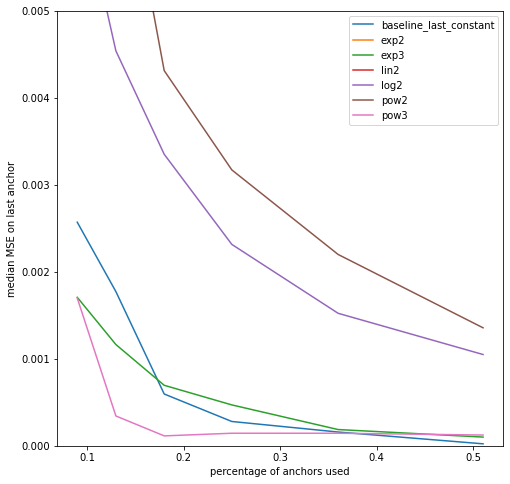

In [44]:
selected = df_total_clean
plt.figure(figsize=(8,8))

for curve_model, df_curve_model in selected.groupby("curve_model"):

    Y = df_curve_model.groupby('percentage')['MSE tst last'].median()
    Y_sigma = df_curve_model.groupby('percentage')['MSE tst last'].std()
    X = df_curve_model.groupby('percentage')['MSE tst last'].median().index

    plt.plot(X,Y,label=curve_model)
    
plt.xlabel('percentage of anchors used')
plt.ylabel('median MSE on last anchor')
plt.legend()
plt.ylim([0,0.005])
plt.show()


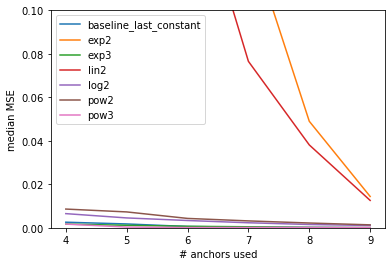

In [19]:
selected = df_total_clean

for curve_model, df_curve_model in selected.groupby("curve_model"):

    Y = df_curve_model.groupby('n')['MSE tst last'].median()
    Y_sigma = df_curve_model.groupby('n')['MSE tst last'].std()
    X = df_curve_model.groupby('n')['MSE tst last'].median().index

    plt.plot(X,Y,label=curve_model)
    
plt.xlabel('# anchors used')
plt.ylabel('median MSE')
plt.legend()
plt.ylim([0,0.1])
plt.show()


In [20]:
df_total_clean.groupby('curve_model')['MSE tst last'].median()

curve_model
baseline_last_constant    0.000394
exp2                      0.150399
exp3                      0.000466
lin2                      0.090508
log2                      0.002344
pow2                      0.003752
pow3                      0.000186
Name: MSE tst last, dtype: float64

In [21]:
df_total_clean['learner']

0                            SVC_linear
1                            SVC_linear
2                            SVC_linear
3                            SVC_linear
4                            SVC_linear
                     ...               
793    sklearn.tree.ExtraTreeClassifier
794    sklearn.tree.ExtraTreeClassifier
795    sklearn.tree.ExtraTreeClassifier
796    sklearn.tree.ExtraTreeClassifier
797    sklearn.tree.ExtraTreeClassifier
Name: learner, Length: 798, dtype: object

In [22]:
df_total_clean.groupby('learner')['MSE tst last'].median()

learner
SVC_linear                                                  1.433169e-03
SVC_poly                                                    7.064049e-03
SVC_rbf                                                     3.349998e-03
SVC_sigmoid                                                 3.687624e-02
sklearn.discriminant_analysis.LinearDiscriminantAnalysis    3.545806e-03
sklearn.ensemble.ExtraTreesClassifier                       2.355872e-03
sklearn.ensemble.GradientBoostingClassifier                 4.153029e-03
sklearn.ensemble.RandomForestClassifier                     2.337776e-03
sklearn.linear_model.LogisticRegression                     2.855361e-03
sklearn.linear_model.PassiveAggressiveClassifier            7.528830e-04
sklearn.linear_model.Perceptron                             1.624935e-03
sklearn.linear_model.RidgeClassifier                        2.126219e-03
sklearn.linear_model.SGDClassifier                          2.054730e-03
sklearn.naive_bayes.BernoulliNB            

In [23]:
df_total_clean.describe()

,openmlid,max_anchor_seen,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n
count,798.0,798.000000,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,7.980000e+02,798.000000,798.000000,798.000000
mean,11.0,127.500000,4.561038e-04,4.534329e+03,1.360296e+04,1.107335e-02,1.460273e+00,4.315737e+00,127.500000,0.253333,6.500000
std,0.0,72.554669,1.444483e-03,1.280884e+05,3.842626e+05,1.349369e-02,3.897671e+01,1.166249e+02,72.554669,0.144158,1.708896
min,11.0,45.000000,3.728600e-31,3.728600e-31,3.728600e-31,6.106227e-16,6.106227e-16,6.106227e-16,45.000000,0.090000,4.000000
25%,11.0,64.000000,1.587121e-05,1.470056e-04,2.185018e-04,3.676366e-03,1.133820e-02,1.478180e-02,64.000000,0.130000,5.000000
50%,11.0,109.500000,6.779601e-05,1.292426e-03,2.693942e-03,7.423349e-03,3.300100e-02,5.190320e-02,109.500000,0.215000,6.500000
75%,11.0,181.000000,2.147159e-04,1.301069e-02,2.376752e-02,1.274350e-02,1.001457e-01,1.541666e-01,181.000000,0.360000,8.000000
max,11.0,256.000000,1.621133e-02,3.618355e+06,1.085499e+07,1.023804e-01,1.101123e+03,3.294692e+03,256.000000,0.510000,9.000000


# Look at parameter values

In [24]:
df_total_clean = df_total_clean.rename(columns={'MSE trn': 'MSE_trn'})

In [25]:
num_curve_models = df_total_clean['curve_model'].unique()
num_curve_models

array(['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2',
       'baseline_last_constant'], dtype=object)

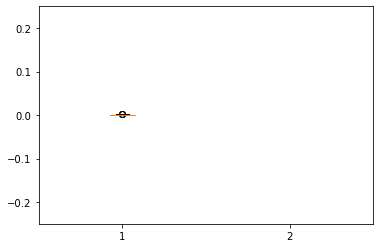

In [26]:
plt.figure()
j = 0
df_selected = df_total_clean.query('curve_model == "lin2"')
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)

    a = np.array(beta_list)
    plt.boxplot(a)
    plt.ylim([-0.25,0.25])


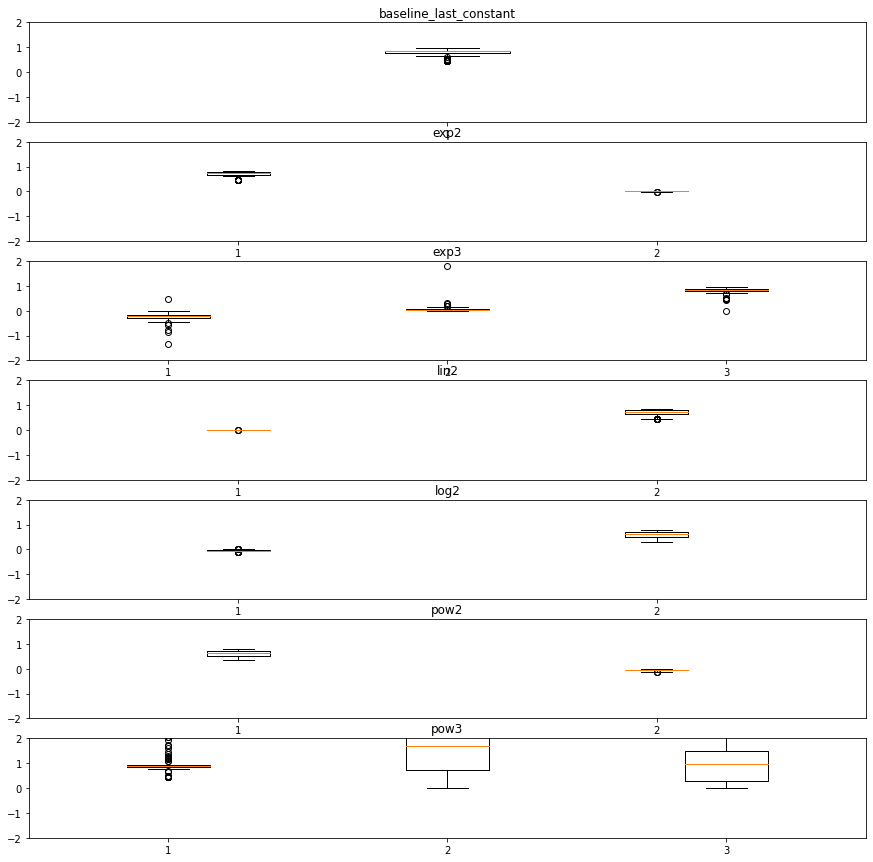

In [27]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

fig, axs = plt.subplots(len(num_curve_models),figsize=(15,15))
j = 0
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)

    a = np.array(beta_list)
    axs[j].boxplot(a)
    axs[j].set_ylim([-2,2])
    axs[j].set_title(curve_model)
    j = j+1

# Visualize fits

In [28]:
df_total_clean

,openmlid,learner,max_anchor_seen,prediction,beta,MSE_trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,11,SVC_linear,45,"[0.8156, 0.8445, 0.856, 0.8613, 0.8638, 0.8648...","(0.8656274024222982, 35.8571101348679, 2.37107...",9.768552e-07,0.000007,0.000037,0.000958,0.001661,0.006106,45,0.09,4,pow3
1,11,SVC_linear,64,"[0.8157, 0.8443, 0.856, 0.8616, 0.8642, 0.8653...","(0.8662253219322855, 30.366008072700684, 2.307...",9.084308e-07,0.000009,0.000045,0.000920,0.001805,0.006706,64,0.13,5,pow3
2,11,SVC_linear,91,"[0.8156, 0.8443, 0.856, 0.8616, 0.8642, 0.8653...","(0.866220983922121, 30.40351700718664, 2.30792...",7.415232e-07,0.000012,0.000045,0.000781,0.002209,0.006706,91,0.18,6,pow3
3,11,SVC_linear,128,"[0.8156, 0.8443, 0.856, 0.8616, 0.8642, 0.8653...","(0.8662195343929074, 30.416578140895297, 2.308...",6.379027e-07,0.000016,0.000045,0.000688,0.002903,0.006706,128,0.25,7,pow3
4,11,SVC_linear,181,"[0.8156, 0.8444, 0.856, 0.8615, 0.864, 0.8651,...","(0.8659982201260854, 32.60429565051816, 2.3343...",6.456780e-07,0.000022,0.000042,0.000684,0.003912,0.006506,181,0.36,8,pow3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,11,sklearn.tree.ExtraTreeClassifier,64,"[0.6898, 0.6898, 0.6898, 0.6898, 0.6898, 0.689...",0.689822,1.931523e-03,0.002636,0.006745,0.036844,0.045189,0.082126,64,0.13,5,baseline_last_constant
794,11,sklearn.tree.ExtraTreeClassifier,91,"[0.7061, 0.7061, 0.7061, 0.7061, 0.7061, 0.706...",0.706109,2.831692e-03,0.001786,0.004333,0.044281,0.036109,0.065826,91,0.18,6,baseline_last_constant
795,11,sklearn.tree.ExtraTreeClassifier,128,"[0.7133, 0.7133, 0.7133, 0.7133, 0.7133, 0.713...",0.713262,3.018111e-03,0.001757,0.003437,0.044129,0.038558,0.058626,128,0.25,7,baseline_last_constant
796,11,sklearn.tree.ExtraTreeClassifier,181,"[0.7316, 0.7316, 0.7316, 0.7316, 0.7316, 0.731...",0.731649,4.347108e-03,0.001021,0.001626,0.054631,0.030362,0.040326,181,0.36,8,baseline_last_constant


In [29]:
learners = df_total_clean['learner'].unique()

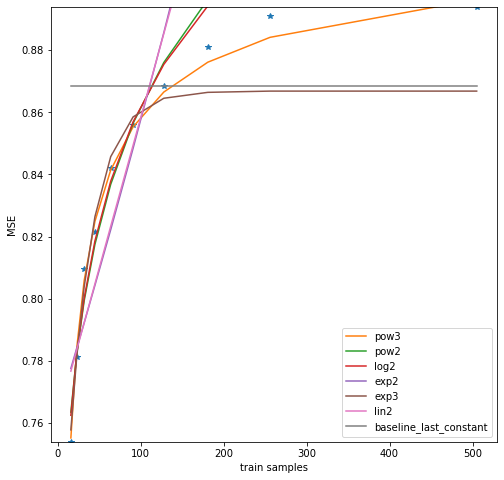

In [40]:
learner = learners[2]
openmlid = 11
n = 7
df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
df_selected

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
for i in range(0,len(df_selected)):
    row = df_selected.iloc[i,:]
    Y_hat = row.prediction
    plt.plot(X,Y_hat,'-',label=row.curve_model)
    
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [31]:
#    def exp3(beta):
#        a, b, c = tuple(beta.astype(float))
#        pl = lambda x: a * np.exp(-b*x) + c

In [32]:
[beta,func] = get_exp2_good_init(X,Y)

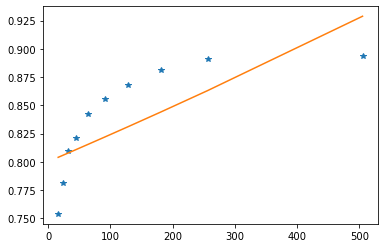

In [33]:
[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

c = 0.89
a = -0.1
b = 0.01

pl = lambda x: a * np.exp(-b*x) + c

plt.figure()
plt.plot(X,Y,'*')
plt.plot(X, func(X))


In [34]:
beta

(0.8002502226307476, -0.00029515091818090196)

# Learner influence

(0.0, 0.1)

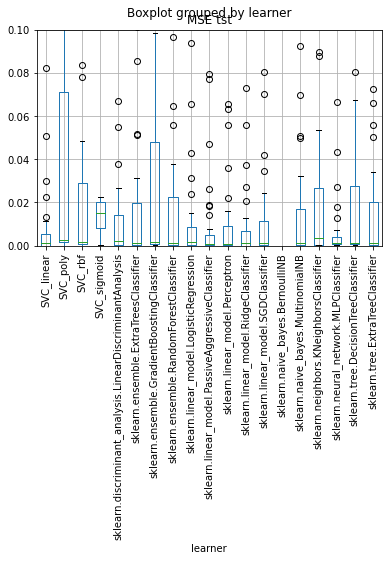

In [35]:
df_total_clean.boxplot(column='MSE tst',by='learner',rot=90)
plt.ylim([0,0.1])

# Curve model influence

(0.0, 0.1)

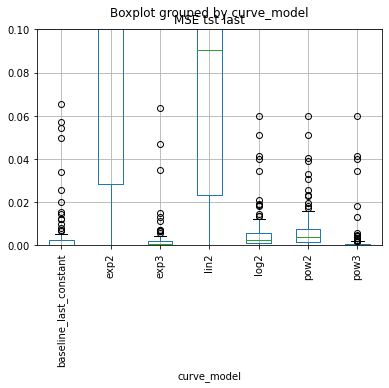

In [41]:
df_total_clean.boxplot(column='MSE tst last',by='curve_model',rot=90)
plt.ylim([0,0.1])